In [1]:
!git clone https://github.com/lopeselio/Behavioral-Cloning-Udacity

Cloning into 'Behavioral-Cloning-Udacity'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 7649 (delta 13), reused 29 (delta 6), pack-reused 7613
Receiving objects: 100% (7649/7649), 99.39 MiB | 35.16 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
!ls Behavioral-Cloning-Udacity


Behavioral_Cloning.ipynb  Data	model.h5  Readme.md


In [19]:
!pip3 install imgaug

In [3]:
!cd Data

/bin/bash: line 0: cd: Data: No such file or directory


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [5]:
datadir = 'Behavioral-Cloning-Udacity/Data/'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_559.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_559.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_559.jpg,0.0,0.0,0,2.216956
1,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_661.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_661.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_661.jpg,0.0,0.0,0,2.143898
2,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_765.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_765.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_765.jpg,0.0,0.0,0,2.044709
3,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_868.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_868.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_868.jpg,0.0,0.0,0,1.946553
4,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_970.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_970.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_970.jpg,0.0,0.0,0,1.847944


In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_05_30_15_20_44_559.jpg,left_2020_05_30_15_20_44_559.jpg,right_2020_05_30_15_20_44_559.jpg,0.0,0.0,0,2.216956
1,center_2020_05_30_15_20_44_661.jpg,left_2020_05_30_15_20_44_661.jpg,right_2020_05_30_15_20_44_661.jpg,0.0,0.0,0,2.143898
2,center_2020_05_30_15_20_44_765.jpg,left_2020_05_30_15_20_44_765.jpg,right_2020_05_30_15_20_44_765.jpg,0.0,0.0,0,2.044709
3,center_2020_05_30_15_20_44_868.jpg,left_2020_05_30_15_20_44_868.jpg,right_2020_05_30_15_20_44_868.jpg,0.0,0.0,0,1.946553
4,center_2020_05_30_15_20_44_970.jpg,left_2020_05_30_15_20_44_970.jpg,right_2020_05_30_15_20_44_970.jpg,0.0,0.0,0,1.847944


**Print an array of steering angles**

# **The bar graph is fairly balanced as we have plots on both sides of the mode, also a huge part of the plot is biased at the zero angle and if the model were trained on this data then we would end up having our self driving vehicle driving in a straight path for most of the time, due to biased training data**

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


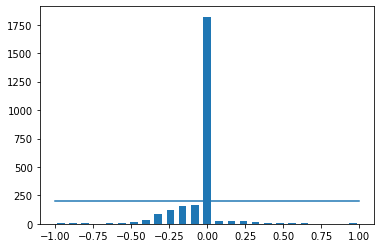

In [7]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Eliminating bias in data by removing certain plots from the data

total data: 2536
removed: 1621
remaining: 915


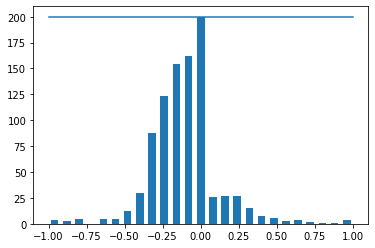

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

# **Training and Validation split**


center      center_2020_05_30_15_20_45_794.jpg
left        left_2020_05_30_15_20_45_794.jpg  
right       right_2020_05_30_15_20_45_794.jpg 
steering   -0.0542256                         
throttle    0                                 
reverse     0                                 
speed       1.05766                           
Name: 12, dtype: object
Training Samples: 2196
Valid Samples: 549


Text(0.5, 1.0, 'Validation set')

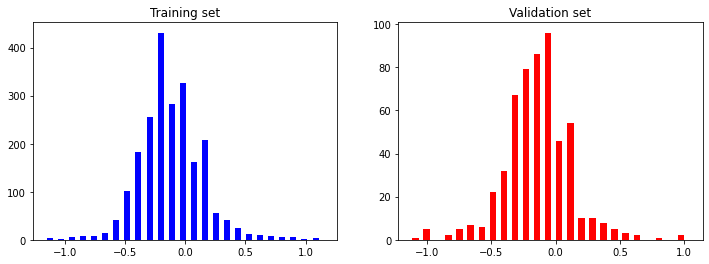

In [20]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

**Here we try to zoom the images to view specific features and extract them**

# **Preprocessing images**

In [0]:

def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

# Augmentation of images

**zooming into the image**

Text(0.5, 1.0, 'Zoomed Image')

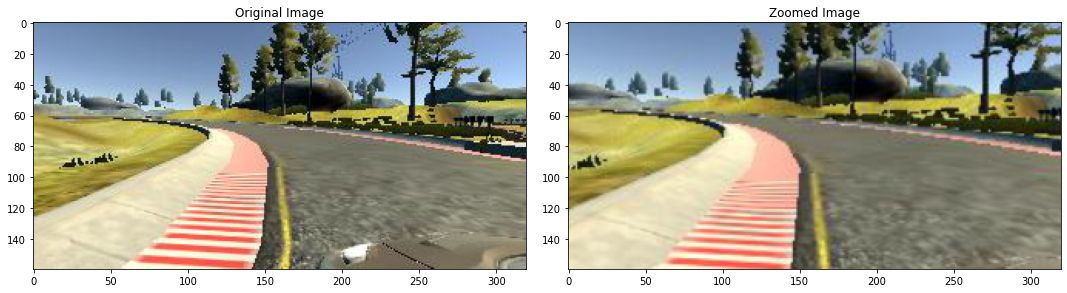

In [24]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

# Panning into the image

Text(0.5, 1.0, 'Panned Image')

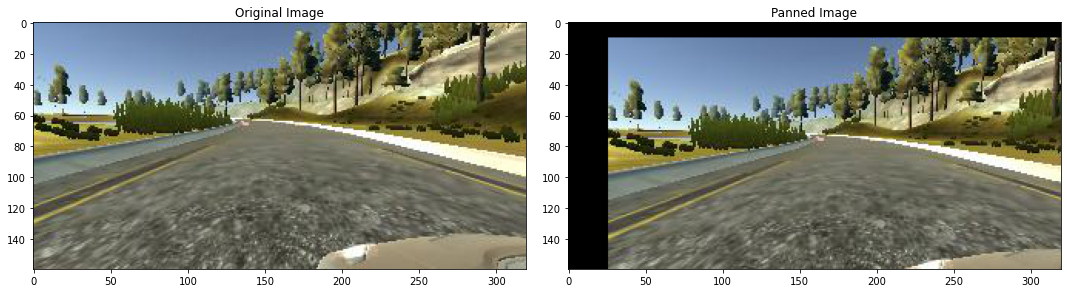

In [26]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

# Altering the Brightness of the image

Text(0.5, 1.0, 'Brightness altered image ')

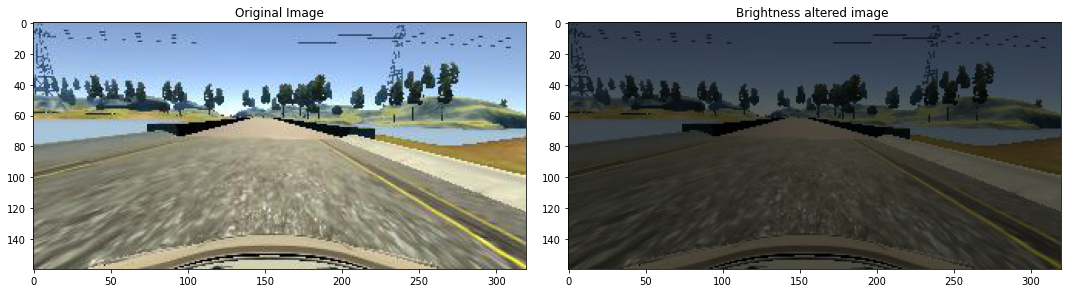

In [27]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

# Image random **Flipping**:

**Image flipping is used to randomly flip generated images so that we balance our datasets. This is similar to the training and validation split bar graphs plotted above which was done to balance steering angle between the positive and well as negative sides**

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.15')

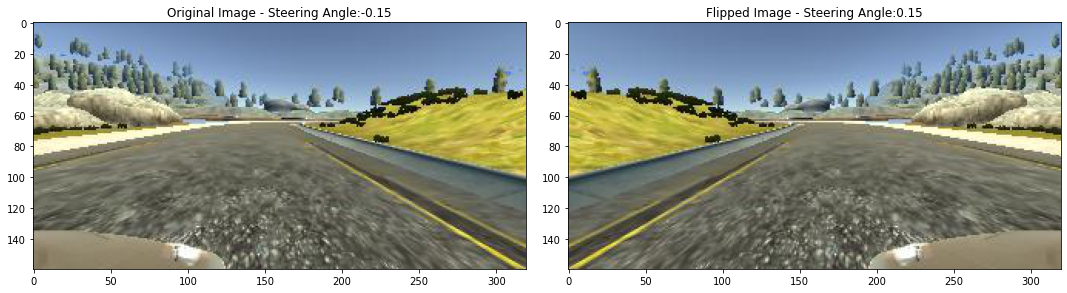

In [29]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

# First we extract useful patches of the images by removing the unwanted region. Using RGB2YUV and Gaussian Blur we remove noise in the image and filter the image followed by image normalization.

TypeError: ignored

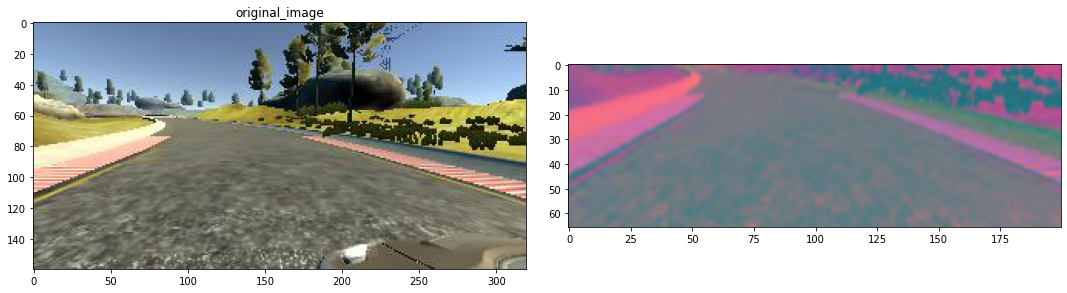

In [10]:
def img_preprocessed(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocessed(image) 

fig, axis = plt.subplots(1,2,figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('original_image')
axis[1].imshow(preprocessed_image)
axis[1].imshow('preprocessed_image')

In [0]:
X_train = np.array(list(map(img_preprocessed, X_train)))
X_valid = np.array(list(map(img_preprocessed, X_valid)))

(2196, 66, 200, 3)


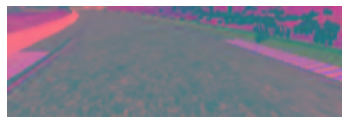

In [12]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
 
  model = Sequential()
  
  model.add(Conv2D(24, kernel_size=(5,5), subsample=(2,2), input_shape=(66,200,3),activation='elu'))
  
  model.add(Conv2D(36, kernel_size=(5,5), subsample=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), subsample=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
 
 
  optimizer= Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [14]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, kernel_size=(5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  """


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, kernel_size=(5, 5), activation="elu", strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, kernel_size=(5, 5), activation="elu", strides=(2, 2))`
  


In [15]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 2196 samples, validate on 549 samples
Epoch 1/30
2196/2196 [==============================] - 8s 3ms/step - loss: 0.3125 - val_loss: 0.0756
Epoch 2/30
2196/2196 [==============================] - 1s 396us/step - loss: 0.0888 - val_loss: 0.0616
Epoch 3/30
2196/2196 [==============================] - 1s 392us/step - loss: 0.0779 - val_loss: 0.0598
Epoch 4/30
2196/2196 [==============================] - 1s 401us/step - loss: 0.0715 - val_loss: 0.0579
Epoch 5/30
2196/2196 [==============================] - 1s 401us/step - loss: 0.0696 - val_loss: 0.0564
Epoch 6/30
2196/2196 [==============================] - 1s 398us/step - loss: 0.0677 - val_loss: 0.0557
Epoch 7/30
2196/2196 [==============================] - 1s 398us/step - loss: 0.0629 - val_loss: 0.0514
Epoch 8/30
2196/2196 [==============================] - 1s 396us/step - loss: 0.0585 - val_loss: 0.0460
Epoch 9/30
2196/2196 [==============================] - 1s 392us/step - loss: 0.0556 - val_loss: 0.0442
Epoch 10/30
2196/21

Text(0.5, 0, 'Epoch')

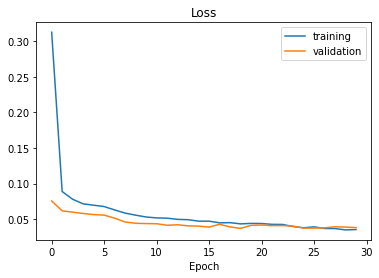

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')